In [1]:
import sys
assert sys.version_info >= (3, 6), "Python 3.6 required for this notebook."

In [2]:
# get latest version of packages
! pip install --upgrade pandas sklearn seaborn jupyterthemes tqdm statsmodels

Requirement already up-to-date: pandas in /Users/pmascolo/anaconda/lib/python3.6/site-packages (0.23.1)
Requirement already up-to-date: sklearn in /Users/pmascolo/anaconda/lib/python3.6/site-packages (0.0)
  Using cached https://files.pythonhosted.org/packages/bc/ee/1921d0f873bd56fca378ad938eaff7cc2ab3e622ed6c035d968924c17677/jupyterthemes-0.19.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/93/24/6ab1df969db228aed36a648a8959d1027099ce45fad67532b9673d533318/tqdm-4.23.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/29/df/1f8233500d8bb90f16fd066560f3805197e568af611ca97eddd5fb81b012/statsmodels-0.9.0-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
Requirement not upgraded as not directly required: python-dateutil>=2.5.0 in /Users/pmascolo/anaconda/lib/python3.6/site-packages (from pandas) (2.7.0)
Requirement not upgraded as not directly required: numpy>=1.9.0 in /Users/

In [3]:
import collections
import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from jupyterthemes import jtplot
from numpy.random import seed
from pandas.plotting import parallel_coordinates

jtplot.style(theme='grade3', ticks=True, grid=False, figsize=(20, 12))

In [4]:
data_file = "../data/time_series_bonds.xlsx"
data = pd.read_excel(data_file, sheet_name="d").set_index("date")
nrows, ncols = data.shape
print(f"Loaded {nrows} rows x {ncols} series")

holed_series = np.array([i if i != 0.0 else np.nan for i in data['n1']])
interpolated = pd.Series(holed_series).interpolate()
interpolated.index = data.index
data['n1'] = interpolated

Loaded 556 rows x 200 series


In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcaed = pca.fit_transform(data.describe().T / data.describe().T.max())
print(pca.explained_variance_ratio_)

[0.9314316  0.06748259]


It's worth remembering that the first PC is mostly driven by standard deviation while all variables contribute to the second.

# Pairwise distances

Presence of clusters can be inferred - to some extent - from the distribution of pairwise distances.

In [6]:
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(pcaed)

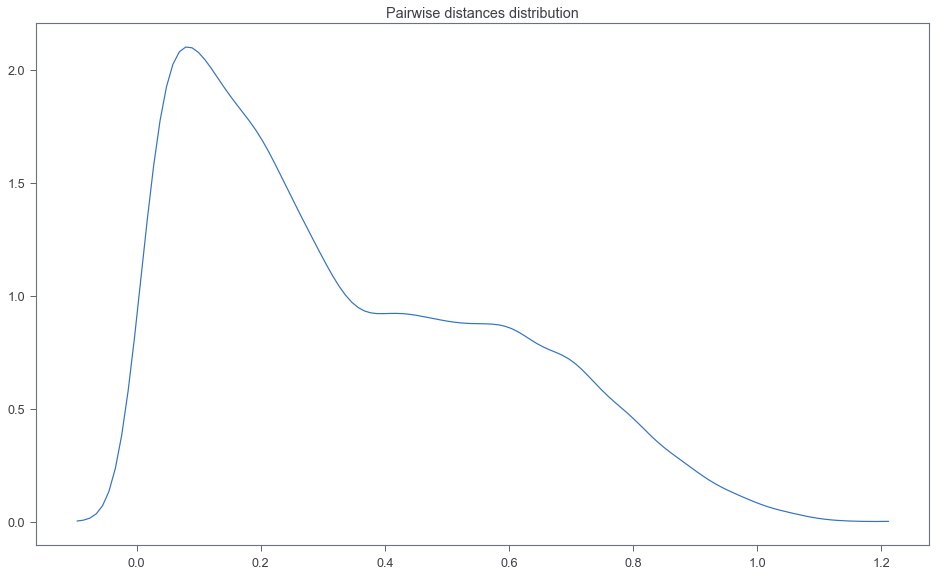

In [7]:
sns.kdeplot(dists.ravel())
plt.title("Pairwise distances distribution")
plt.show()

The curve in the graph suggests the presence of one strong cluster (which is confirmed by the PC scatterplot). There are no other clear indications of strong clusters, as confirmed by the sparse set of points at high levels of the first PC.

# Density based approach on embeddings
## Principal components
### DBSCAN

In [8]:
from sklearn.cluster import DBSCAN, estimate_bandwidth, MeanShift
from sklearn.mixture import GMM

In [9]:
dbscan = DBSCAN(eps=0.05)
dbscan.fit(pcaed)
print(f"{len(set(dbscan.labels_))} clusters determined by DBSCAN")

7 clusters determined by DBSCAN


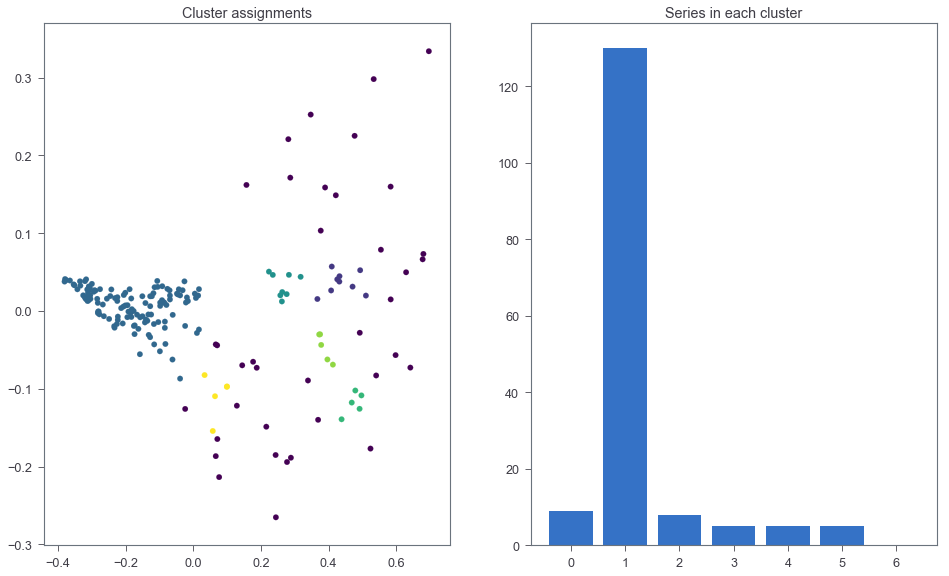

In [10]:
plt.subplot(1, 2, 1)
plt.scatter(*list(zip(*pcaed)), c=dbscan.labels_, cmap="viridis")
plt.title("Cluster assignments")

plt.subplot(1, 2, 2)
labels = collections.Counter(dbscan.labels_)
xs = range(len(labels))
plt.bar(xs, [labels[i] for i in xs])
plt.xticks(xs, xs)
plt.title("Series in each cluster")
plt.show()

### Meanshift

In [11]:
ms = MeanShift(bandwidth=0.12)
ms.fit(pcaed)
print(f"{len(set(ms.labels_))} clusters determined by MeanShift")

10 clusters determined by MeanShift


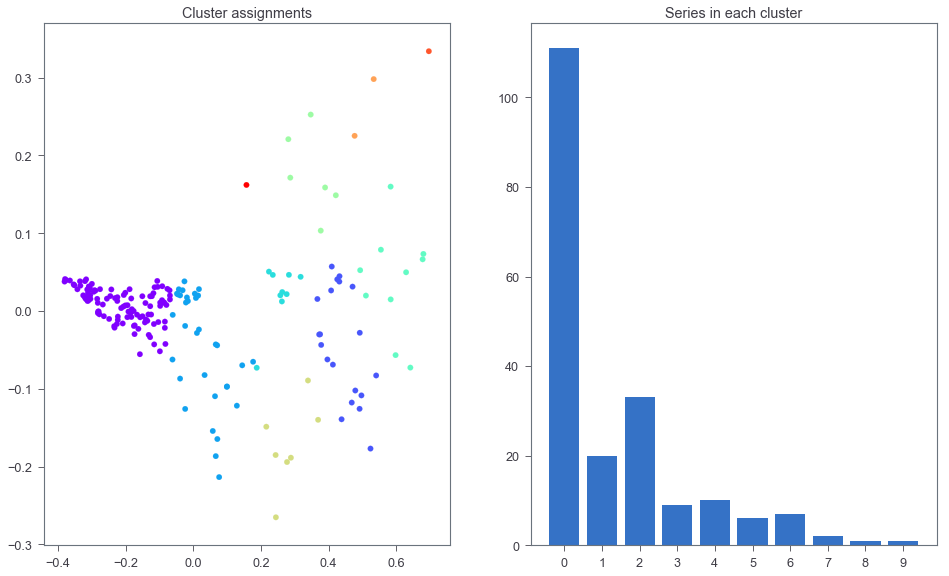

In [12]:
plt.subplot(1, 2, 1)
plt.scatter(*list(zip(*pcaed)), c=ms.labels_, cmap="rainbow")
plt.title("Cluster assignments")

plt.subplot(1, 2, 2)
labels = collections.Counter(ms.labels_)
xs = range(len(labels))
plt.bar(xs, [labels[i] for i in xs])
plt.xticks(xs, xs)
plt.title("Series in each cluster")
plt.show()

### GMM

In [13]:
from sklearn.mixture import BayesianGaussianMixture
gmm = BayesianGaussianMixture(n_components=50)
gmm.fit(pcaed)
labs = gmm.predict(pcaed)
print(f"{len(set(labs))} clusters determined by GMM")

6 clusters determined by GMM


In [14]:
from numpy import linalg

In [15]:
import matplotlib

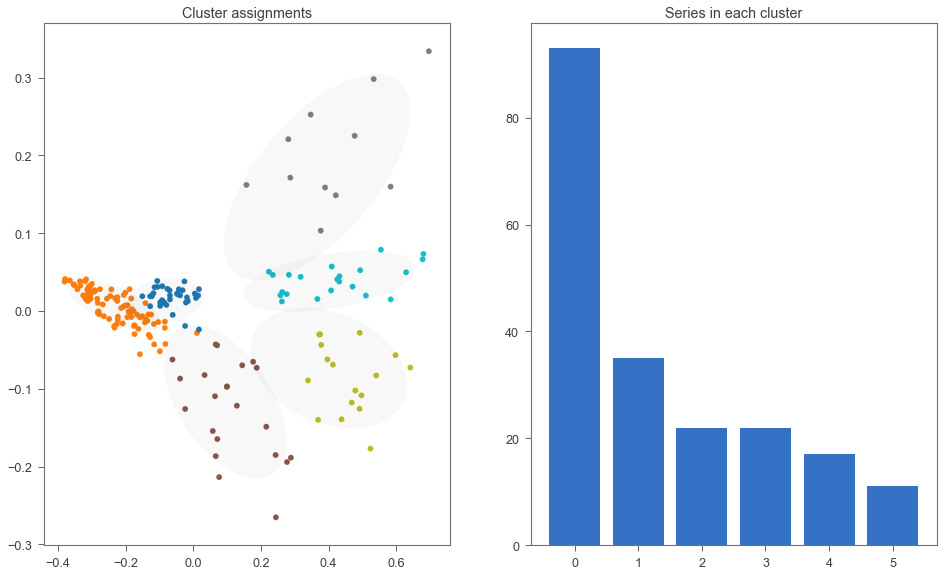

In [16]:
p = plt.subplot(1, 2, 1)
plt.scatter(*list(zip(*pcaed)), c=labs, cmap="tab10")
for n, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    if n not in set(labs):
        continue
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi
    ell = matplotlib.patches.Ellipse(mean, v[0], v[1], 180 + angle, color='k')
    ell.set_alpha(0.03)
    plt.title("Cluster assignments")
    p.add_artist(ell)

plt.subplot(1, 2, 2)
labels = collections.Counter(labs)
xs = range(len(labels))
plt.bar(xs, [v for v in sorted(labels.values(), reverse=True)])
plt.xticks(xs, xs)
plt.title("Series in each cluster")
plt.show()

# Time series clustering with DTW

In [24]:
from tslearn import utils, clustering

In [25]:
series = utils.to_time_series_dataset(data.T.values)

In [26]:
%%time
km = clustering.TimeSeriesKMeans(n_clusters=15, metric="softdtw", maxiter=10)
x = km.fit_predict(series)

490546.881 --> 626918.560 --> 632495.509 --> 634488.797 --> 634892.138 --> 635498.783 --> 635841.095 --> 636069.355 --> 636109.689 --> 636110.252 --> 636284.629 --> 636511.359 --> 636562.988 --> 636922.053 --> 637002.517 --> 637079.026 --> 637121.572 --> 637136.911 --> 637350.231 --> 637316.461 --> 637351.414 --> 637344.739 --> 637392.314 --> 637398.479 --> 637394.169 --> 637465.153 --> 637488.346 --> 637516.896 --> 637614.636 --> 637610.439 --> 637709.690 --> 637773.281 --> 637778.034 --> 637806.642 --> 637811.179 --> 637815.405 --> 637831.923 --> 637836.270 --> 637846.106 --> 637851.328 --> 637858.766 --> 637862.478 --> 637867.922 --> 637872.055 --> 637878.314 --> 637874.855 --> 637888.018 --> 637885.942 --> 637895.202 --> 637893.307 --> 
CPU times: user 1h 10min 52s, sys: 1min 32s, total: 1h 12min 24s
Wall time: 1h 12min


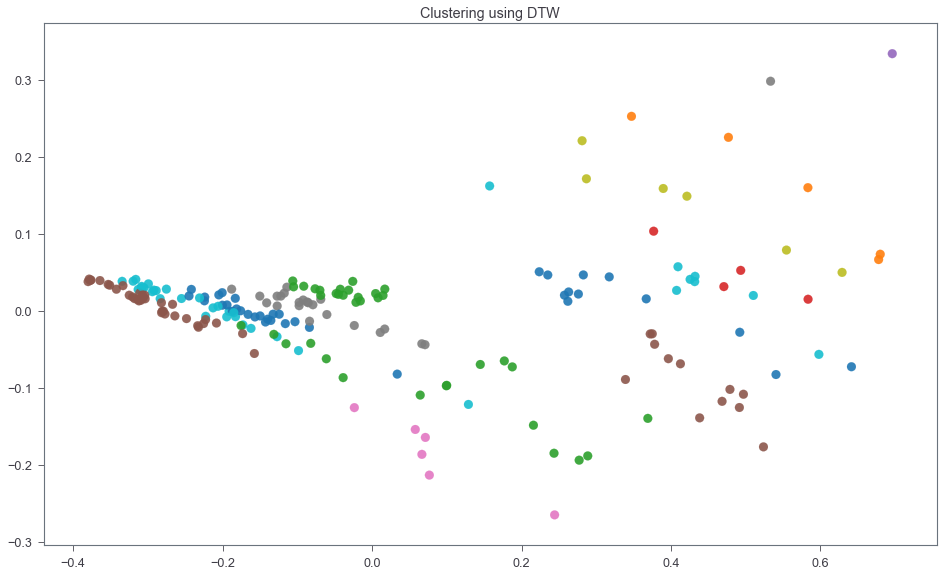

In [36]:
plt.scatter(*list(zip(*pcaed)), c=x, cmap='tab10', s=80, alpha=0.9)
plt.title("Clustering using DTW")
plt.show()